# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 3796, 1.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [15]:
learnRate = 0.001
graficoName = "oversampling SMOTE, lr=0.001, rede="

## RNA 1 (10)

In [17]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 1s - loss: 0.2134 - acc: 0.7208 - val_loss: 0.1729 - val_acc: 0.7626
Epoch 2/100000
7592/7592 [==============================] - 1s - loss: 0.1752 - acc: 0.7648 - val_loss: 0.1473 - val_acc: 0.7908
Epoch 3/100000
7592/7592 [==============================] - 1s - loss: 0.1530 - acc: 0.7932 - val_loss: 0.1320 - val_acc: 0.8190
Epoch 4/100000
7592/7592 [==============================] - 1s - loss: 0.1388 - acc: 0.8112 - val_loss: 0.1236 - val_acc: 0.8359
Epoch 5/100000
7592/7592 [==============================] - 1s - loss: 0.1289 - acc: 0.8267 - val_loss: 0.1185 - val_acc: 0.8435
Epoch 6/100000
7592/7592 [==============================] - 1s - loss: 0.1213 - acc: 0.8392 - val_loss: 0.1159 - val_acc: 0.8477
Epoch 7/100000
7592/7592 [==============================] - 1s - loss: 0.1152 - acc: 0.8533 - val_loss: 0.1143 - val_acc: 0.8509
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 1s - loss: 0.0697 - acc: 0.9251 - val_loss: 0.0848 - val_acc: 0.8994
Epoch 126/100000
7592/7592 [==============================] - 1s - loss: 0.0696 - acc: 0.9251 - val_loss: 0.0849 - val_acc: 0.8986
Epoch 127/100000
7592/7592 [==============================] - 1s - loss: 0.0695 - acc: 0.9252 - val_loss: 0.0846 - val_acc: 0.8994
Epoch 128/100000
7592/7592 [==============================] - 1s - loss: 0.0694 - acc: 0.9254 - val_loss: 0.0846 - val_acc: 0.8988
Epoch 129/100000
7592/7592 [==============================] - 1s - loss: 0.0693 - acc: 0.9253 - val_loss: 0.0845 - val_acc: 0.8986
Epoch 130/100000
7592/7592 [==============================] - 1s - loss: 0.0692 - acc: 0.9256 - val_loss: 0.0844 - val_acc: 0.8991
Epoch 131/100000
7592/7592 [==============================] - 1s - loss: 0.0691 - acc: 0.9256 - val_loss: 0.0842 - val_acc: 0.8999
Epoch 132/100000
7592/7592 [==============================] - 1s - loss: 0.0690 - acc: 0.9258 - val_

7592/7592 [==============================] - 0s - loss: 0.0621 - acc: 0.9310 - val_loss: 0.0764 - val_acc: 0.9052
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9311 - val_loss: 0.0764 - val_acc: 0.9052
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9314 - val_loss: 0.0763 - val_acc: 0.9049
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9314 - val_loss: 0.0764 - val_acc: 0.9054
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9312 - val_loss: 0.0764 - val_acc: 0.9052
Epoch 254/100000
7592/7592 [==============================] - 1s - loss: 0.0619 - acc: 0.9316 - val_loss: 0.0763 - val_acc: 0.9049
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9311 - val_loss: 0.0763 - val_acc: 0.9052
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9314 - val_

In [18]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.053082526992782417, 0.94036697247706424]


<IPython.core.display.Javascript object>


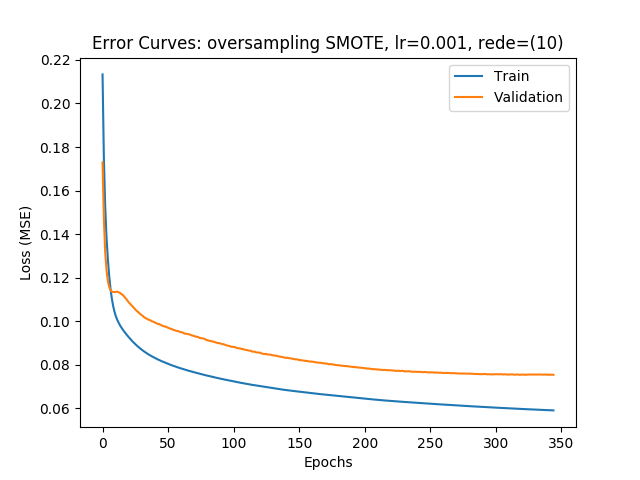

<IPython.core.display.Javascript object>


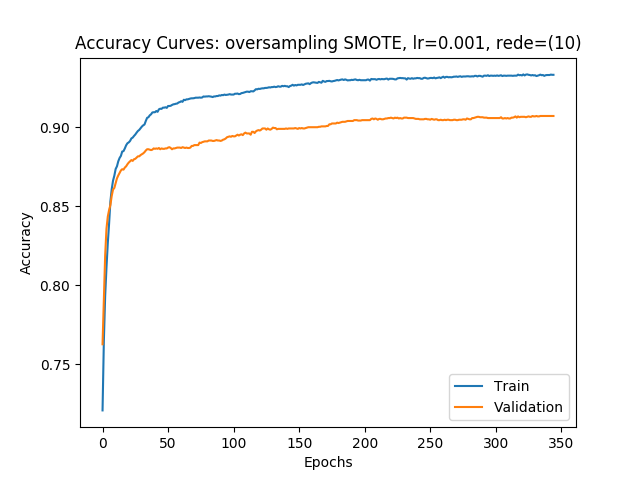

Matriz de confusão
[[1788  110]
 [   6   58]]

Train Loss:       0.0595
Validation Loss:  0.0752
Accuracy:         0.9409
MSE:              0.0591
AUROC:            0.9634


In [20]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [21]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 1s - loss: 0.5830 - acc: 0.3759 - val_loss: 0.5233 - val_acc: 0.3957
Epoch 2/100000
7592/7592 [==============================] - 1s - loss: 0.5199 - acc: 0.4401 - val_loss: 0.5046 - val_acc: 0.4831
Epoch 3/100000
7592/7592 [==============================] - 1s - loss: 0.5058 - acc: 0.4934 - val_loss: 0.4998 - val_acc: 0.4982
Epoch 4/100000
7592/7592 [==============================] - 1s - loss: 0.4995 - acc: 0.5001 - val_loss: 0.4964 - val_acc: 0.4960
Epoch 5/100000
7592/7592 [==============================] - 1s - loss: 0.4858 - acc: 0.5022 - val_loss: 0.4834 - val_acc: 0.5053
Epoch 6/100000
7592/7592 [==============================] - 1s - loss: 0.4700 - acc: 0.5150 - val_loss: 0.4746 - val_acc: 0.5158
Epoch 7/100000
7592/7592 [==============================] - 1s - loss: 0.4631 - acc: 0.5248 - val_loss: 0.4704 - val_acc: 0.5200
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0734 - acc: 0.9197 - val_loss: 0.0790 - val_acc: 0.8991
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0732 - acc: 0.9203 - val_loss: 0.0787 - val_acc: 0.8996
Epoch 65/100000
7592/7592 [==============================] - 0s - loss: 0.0730 - acc: 0.9206 - val_loss: 0.0785 - val_acc: 0.8994
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0728 - acc: 0.9206 - val_loss: 0.0783 - val_acc: 0.8999
Epoch 67/100000
7592/7592 [==============================] - 0s - loss: 0.0726 - acc: 0.9208 - val_loss: 0.0782 - val_acc: 0.8996
Epoch 68/100000
7592/7592 [==============================] - 0s - loss: 0.0724 - acc: 0.9218 - val_loss: 0.0780 - val_acc: 0.9004
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0722 - acc: 0.9218 - val_loss: 0.0779 - val_acc: 0.9004
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0720 - acc: 0.9219 - val_loss: 0

7592/7592 [==============================] - 1s - loss: 0.0656 - acc: 0.9268 - val_loss: 0.0740 - val_acc: 0.9012
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0656 - acc: 0.9273 - val_loss: 0.0739 - val_acc: 0.9009
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0655 - acc: 0.9274 - val_loss: 0.0738 - val_acc: 0.9009
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9276 - val_loss: 0.0737 - val_acc: 0.9015
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0653 - acc: 0.9273 - val_loss: 0.0738 - val_acc: 0.9002
Epoch 130/100000
7592/7592 [==============================] - 1s - loss: 0.0652 - acc: 0.9272 - val_loss: 0.0738 - val_acc: 0.9002
Epoch 131/100000
7592/7592 [==============================] - 1s - loss: 0.0652 - acc: 0.9272 - val_loss: 0.0737 - val_acc: 0.9020
Epoch 132/100000
7592/7592 [==============================] - 1s - loss: 0.0651 - acc: 0.9273 - val_

7592/7592 [==============================] - 0s - loss: 0.0614 - acc: 0.9291 - val_loss: 0.0720 - val_acc: 0.9038
Epoch 188/100000
7592/7592 [==============================] - 0s - loss: 0.0613 - acc: 0.9291 - val_loss: 0.0717 - val_acc: 0.9044
Epoch 189/100000
7592/7592 [==============================] - 0s - loss: 0.0612 - acc: 0.9295 - val_loss: 0.0718 - val_acc: 0.9044
Epoch 190/100000
7592/7592 [==============================] - 0s - loss: 0.0612 - acc: 0.9295 - val_loss: 0.0718 - val_acc: 0.9044
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0611 - acc: 0.9293 - val_loss: 0.0718 - val_acc: 0.9044
Epoch 192/100000
7592/7592 [==============================] - 0s - loss: 0.0611 - acc: 0.9295 - val_loss: 0.0716 - val_acc: 0.9044
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0610 - acc: 0.9295 - val_loss: 0.0717 - val_acc: 0.9044
Epoch 194/100000
7592/7592 [==============================] - 0s - loss: 0.0609 - acc: 0.9295 - val_

7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9330 - val_loss: 0.0699 - val_acc: 0.9089
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9327 - val_loss: 0.0701 - val_acc: 0.9086
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9331 - val_loss: 0.0700 - val_acc: 0.9086
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9330 - val_loss: 0.0699 - val_acc: 0.9089
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9330 - val_loss: 0.0699 - val_acc: 0.9086
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9328 - val_loss: 0.0700 - val_acc: 0.9089
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9332 - val_loss: 0.0700 - val_acc: 0.9089
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9331 - val_

7592/7592 [==============================] - 1s - loss: 0.0554 - acc: 0.9341 - val_loss: 0.0686 - val_acc: 0.9112
Epoch 312/100000
7592/7592 [==============================] - 1s - loss: 0.0553 - acc: 0.9340 - val_loss: 0.0688 - val_acc: 0.9107
Epoch 313/100000
7592/7592 [==============================] - 1s - loss: 0.0553 - acc: 0.9345 - val_loss: 0.0686 - val_acc: 0.9110
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0553 - acc: 0.9341 - val_loss: 0.0687 - val_acc: 0.9112
Epoch 315/100000
7592/7592 [==============================] - 1s - loss: 0.0552 - acc: 0.9347 - val_loss: 0.0687 - val_acc: 0.9112
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9349 - val_loss: 0.0686 - val_acc: 0.9110
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9348 - val_loss: 0.0686 - val_acc: 0.9115
Epoch 318/100000
7592/7592 [==============================] - 0s - loss: 0.0551 - acc: 0.9347 - val_

7592/7592 [==============================] - 1s - loss: 0.0533 - acc: 0.9391 - val_loss: 0.0676 - val_acc: 0.9125
Epoch 374/100000
7592/7592 [==============================] - 1s - loss: 0.0533 - acc: 0.9397 - val_loss: 0.0676 - val_acc: 0.9112
Epoch 375/100000
7592/7592 [==============================] - 1s - loss: 0.0533 - acc: 0.9393 - val_loss: 0.0676 - val_acc: 0.9112
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0532 - acc: 0.9395 - val_loss: 0.0677 - val_acc: 0.9112
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0532 - acc: 0.9393 - val_loss: 0.0675 - val_acc: 0.9112
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0532 - acc: 0.9395 - val_loss: 0.0676 - val_acc: 0.9115
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9397 - val_loss: 0.0675 - val_acc: 0.9112
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9395 - val_

7592/7592 [==============================] - 1s - loss: 0.0515 - acc: 0.9414 - val_loss: 0.0667 - val_acc: 0.9146
Epoch 436/100000
7592/7592 [==============================] - 1s - loss: 0.0515 - acc: 0.9411 - val_loss: 0.0667 - val_acc: 0.9144
Epoch 437/100000
7592/7592 [==============================] - 1s - loss: 0.0515 - acc: 0.9415 - val_loss: 0.0666 - val_acc: 0.9154
Epoch 438/100000
7592/7592 [==============================] - 1s - loss: 0.0515 - acc: 0.9416 - val_loss: 0.0668 - val_acc: 0.9146
Epoch 439/100000
7592/7592 [==============================] - 1s - loss: 0.0514 - acc: 0.9418 - val_loss: 0.0667 - val_acc: 0.9141
Epoch 440/100000
7592/7592 [==============================] - 1s - loss: 0.0514 - acc: 0.9418 - val_loss: 0.0667 - val_acc: 0.9146
Epoch 441/100000
7592/7592 [==============================] - 1s - loss: 0.0514 - acc: 0.9413 - val_loss: 0.0668 - val_acc: 0.9146
Epoch 442/100000
7592/7592 [==============================] - 1s - loss: 0.0514 - acc: 0.9413 - val_

7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9428 - val_loss: 0.0659 - val_acc: 0.9170
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9431 - val_loss: 0.0660 - val_acc: 0.9165
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9427 - val_loss: 0.0659 - val_acc: 0.9165
Epoch 500/100000
7592/7592 [==============================] - 1s - loss: 0.0499 - acc: 0.9427 - val_loss: 0.0659 - val_acc: 0.9165
Epoch 501/100000
7592/7592 [==============================] - 1s - loss: 0.0499 - acc: 0.9428 - val_loss: 0.0660 - val_acc: 0.9162
Epoch 502/100000
7592/7592 [==============================] - 1s - loss: 0.0499 - acc: 0.9426 - val_loss: 0.0659 - val_acc: 0.9165
Epoch 503/100000
7592/7592 [==============================] - 1s - loss: 0.0499 - acc: 0.9428 - val_loss: 0.0659 - val_acc: 0.9165
Epoch 504/100000
7592/7592 [==============================] - 1s - loss: 0.0498 - acc: 0.9427 - val_

7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9440 - val_loss: 0.0651 - val_acc: 0.9191
Epoch 560/100000
7592/7592 [==============================] - 0s - loss: 0.0486 - acc: 0.9442 - val_loss: 0.0650 - val_acc: 0.9194
Epoch 561/100000
7592/7592 [==============================] - 0s - loss: 0.0486 - acc: 0.9444 - val_loss: 0.0651 - val_acc: 0.9186
Epoch 562/100000
7592/7592 [==============================] - 0s - loss: 0.0486 - acc: 0.9440 - val_loss: 0.0651 - val_acc: 0.9189
Epoch 563/100000
7592/7592 [==============================] - 1s - loss: 0.0486 - acc: 0.9439 - val_loss: 0.0650 - val_acc: 0.9189
Epoch 564/100000
7592/7592 [==============================] - 1s - loss: 0.0486 - acc: 0.9442 - val_loss: 0.0650 - val_acc: 0.9186
Epoch 565/100000
7592/7592 [==============================] - 1s - loss: 0.0485 - acc: 0.9445 - val_loss: 0.0650 - val_acc: 0.9191
Epoch 566/100000
7592/7592 [==============================] - 1s - loss: 0.0485 - acc: 0.9442 - val_

7592/7592 [==============================] - 1s - loss: 0.0475 - acc: 0.9451 - val_loss: 0.0643 - val_acc: 0.9202
Epoch 622/100000
7592/7592 [==============================] - 1s - loss: 0.0474 - acc: 0.9452 - val_loss: 0.0643 - val_acc: 0.9199
Epoch 623/100000
7592/7592 [==============================] - 1s - loss: 0.0474 - acc: 0.9452 - val_loss: 0.0643 - val_acc: 0.9197
Epoch 624/100000
7592/7592 [==============================] - 1s - loss: 0.0474 - acc: 0.9452 - val_loss: 0.0643 - val_acc: 0.9199
Epoch 625/100000
7592/7592 [==============================] - 1s - loss: 0.0474 - acc: 0.9452 - val_loss: 0.0643 - val_acc: 0.9202
Epoch 626/100000
7592/7592 [==============================] - 0s - loss: 0.0474 - acc: 0.9451 - val_loss: 0.0643 - val_acc: 0.9197
Epoch 627/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9452 - val_loss: 0.0642 - val_acc: 0.9197
Epoch 628/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9455 - val_

7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9464 - val_loss: 0.0636 - val_acc: 0.9212
Epoch 684/100000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9461 - val_loss: 0.0637 - val_acc: 0.9210
Epoch 685/100000
7592/7592 [==============================] - 0s - loss: 0.0462 - acc: 0.9463 - val_loss: 0.0636 - val_acc: 0.9212
Epoch 686/100000
7592/7592 [==============================] - 0s - loss: 0.0462 - acc: 0.9465 - val_loss: 0.0637 - val_acc: 0.9204
Epoch 687/100000
7592/7592 [==============================] - 1s - loss: 0.0462 - acc: 0.9464 - val_loss: 0.0636 - val_acc: 0.9207
Epoch 688/100000
7592/7592 [==============================] - 0s - loss: 0.0462 - acc: 0.9460 - val_loss: 0.0636 - val_acc: 0.9210
Epoch 689/100000
7592/7592 [==============================] - 0s - loss: 0.0462 - acc: 0.9460 - val_loss: 0.0635 - val_acc: 0.9210
Epoch 690/100000
7592/7592 [==============================] - 1s - loss: 0.0462 - acc: 0.9463 - val_

7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9468 - val_loss: 0.0629 - val_acc: 0.9212
Epoch 746/100000
7592/7592 [==============================] - 1s - loss: 0.0453 - acc: 0.9467 - val_loss: 0.0629 - val_acc: 0.9215
Epoch 747/100000
7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9469 - val_loss: 0.0629 - val_acc: 0.9215
Epoch 748/100000
7592/7592 [==============================] - 1s - loss: 0.0452 - acc: 0.9470 - val_loss: 0.0629 - val_acc: 0.9212
Epoch 749/100000
7592/7592 [==============================] - 1s - loss: 0.0452 - acc: 0.9470 - val_loss: 0.0628 - val_acc: 0.9220
Epoch 750/100000
7592/7592 [==============================] - 1s - loss: 0.0452 - acc: 0.9469 - val_loss: 0.0628 - val_acc: 0.9218
Epoch 751/100000
7592/7592 [==============================] - 1s - loss: 0.0452 - acc: 0.9469 - val_loss: 0.0628 - val_acc: 0.9215
Epoch 752/100000
7592/7592 [==============================] - 1s - loss: 0.0452 - acc: 0.9467 - val_

7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9476 - val_loss: 0.0625 - val_acc: 0.9226
Epoch 808/100000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9477 - val_loss: 0.0623 - val_acc: 0.9228
Epoch 809/100000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9476 - val_loss: 0.0623 - val_acc: 0.9228
Epoch 810/100000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9478 - val_loss: 0.0623 - val_acc: 0.9226
Epoch 811/100000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9478 - val_loss: 0.0623 - val_acc: 0.9231
Epoch 812/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9477 - val_loss: 0.0623 - val_acc: 0.9228
Epoch 813/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9480 - val_loss: 0.0623 - val_acc: 0.9226
Epoch 814/100000
7592/7592 [==============================] - 1s - loss: 0.0444 - acc: 0.9480 - val_

7592/7592 [==============================] - 0s - loss: 0.0439 - acc: 0.9477 - val_loss: 0.0619 - val_acc: 0.9231
Epoch 870/100000
7592/7592 [==============================] - 0s - loss: 0.0439 - acc: 0.9477 - val_loss: 0.0619 - val_acc: 0.9241
Epoch 871/100000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9476 - val_loss: 0.0619 - val_acc: 0.9244
Epoch 872/100000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9476 - val_loss: 0.0619 - val_acc: 0.9233
Epoch 873/100000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9481 - val_loss: 0.0619 - val_acc: 0.9239
Epoch 874/100000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9476 - val_loss: 0.0620 - val_acc: 0.9241
Epoch 875/100000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9481 - val_loss: 0.0618 - val_acc: 0.9247
Epoch 876/100000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9480 - val_

7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9477 - val_loss: 0.0616 - val_acc: 0.9233
Epoch 932/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9481 - val_loss: 0.0617 - val_acc: 0.9233
Epoch 933/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9484 - val_loss: 0.0617 - val_acc: 0.9233
Epoch 934/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9480 - val_loss: 0.0617 - val_acc: 0.9236
Epoch 935/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9480 - val_loss: 0.0616 - val_acc: 0.9233
Epoch 936/100000
7592/7592 [==============================] - 0s - loss: 0.0433 - acc: 0.9482 - val_loss: 0.0617 - val_acc: 0.9233
Epoch 937/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9480 - val_loss: 0.0617 - val_acc: 0.9233
Epoch 938/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9481 - val_

7592/7592 [==============================] - 1s - loss: 0.0428 - acc: 0.9484 - val_loss: 0.0614 - val_acc: 0.9239


In [22]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.043332393878309491, 0.94903160040774714]


<IPython.core.display.Javascript object>


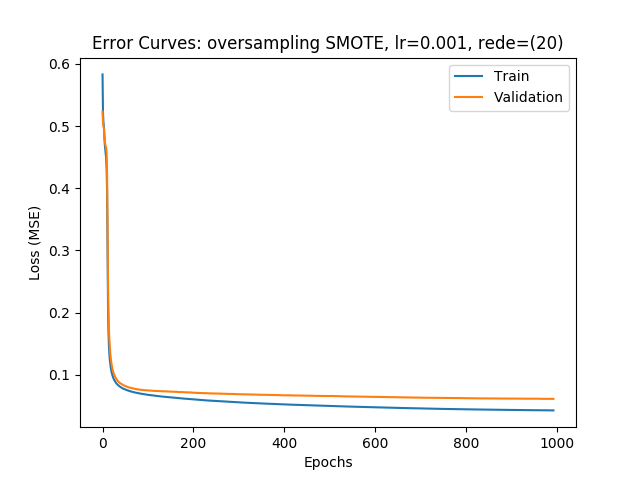

<IPython.core.display.Javascript object>


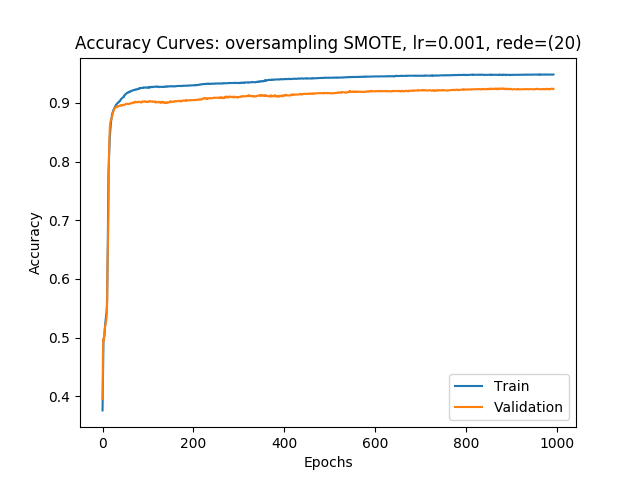

Matriz de confusão
[[1807   91]
 [   9   55]]

Train Loss:       0.0430
Validation Loss:  0.0614
Accuracy:         0.9490
MSE:              0.0510
AUROC:            0.9600


In [23]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [26]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 1s - loss: 0.4966 - acc: 0.4781 - val_loss: 0.4481 - val_acc: 0.4839
Epoch 2/100000
7592/7592 [==============================] - 1s - loss: 0.3728 - acc: 0.5020 - val_loss: 0.2592 - val_acc: 0.5656
Epoch 3/100000
7592/7592 [==============================] - 1s - loss: 0.2224 - acc: 0.6595 - val_loss: 0.1948 - val_acc: 0.6965
Epoch 4/100000
7592/7592 [==============================] - 1s - loss: 0.1846 - acc: 0.7491 - val_loss: 0.1786 - val_acc: 0.7329
Epoch 5/100000
7592/7592 [==============================] - 1s - loss: 0.1696 - acc: 0.7795 - val_loss: 0.1704 - val_acc: 0.7600
Epoch 6/100000
7592/7592 [==============================] - 1s - loss: 0.1601 - acc: 0.7966 - val_loss: 0.1645 - val_acc: 0.7819
Epoch 7/100000
7592/7592 [==============================] - 1s - loss: 0.1529 - acc: 0.8081 - val_loss: 0.1595 - val_acc: 0.7927
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 1s - loss: 0.0742 - acc: 0.9171 - val_loss: 0.0970 - val_acc: 0.8754
Epoch 64/100000
7592/7592 [==============================] - 1s - loss: 0.0739 - acc: 0.9174 - val_loss: 0.0966 - val_acc: 0.8764
Epoch 65/100000
7592/7592 [==============================] - 1s - loss: 0.0736 - acc: 0.9174 - val_loss: 0.0962 - val_acc: 0.8770
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0733 - acc: 0.9170 - val_loss: 0.0961 - val_acc: 0.8772
Epoch 67/100000
7592/7592 [==============================] - 1s - loss: 0.0730 - acc: 0.9177 - val_loss: 0.0962 - val_acc: 0.8788
Epoch 68/100000
7592/7592 [==============================] - 1s - loss: 0.0727 - acc: 0.9175 - val_loss: 0.0956 - val_acc: 0.8809
Epoch 69/100000
7592/7592 [==============================] - 1s - loss: 0.0725 - acc: 0.9185 - val_loss: 0.0954 - val_acc: 0.8815
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0722 - acc: 0.9186 - val_loss: 0

7592/7592 [==============================] - 1s - loss: 0.0639 - acc: 0.9280 - val_loss: 0.0857 - val_acc: 0.8959
Epoch 126/100000
7592/7592 [==============================] - 1s - loss: 0.0638 - acc: 0.9277 - val_loss: 0.0853 - val_acc: 0.8957
Epoch 127/100000
7592/7592 [==============================] - 1s - loss: 0.0637 - acc: 0.9281 - val_loss: 0.0853 - val_acc: 0.8959
Epoch 128/100000
7592/7592 [==============================] - 1s - loss: 0.0636 - acc: 0.9283 - val_loss: 0.0850 - val_acc: 0.8959
Epoch 129/100000
7592/7592 [==============================] - 1s - loss: 0.0635 - acc: 0.9278 - val_loss: 0.0849 - val_acc: 0.8962
Epoch 130/100000
7592/7592 [==============================] - 1s - loss: 0.0634 - acc: 0.9282 - val_loss: 0.0848 - val_acc: 0.8967
Epoch 131/100000
7592/7592 [==============================] - 1s - loss: 0.0633 - acc: 0.9278 - val_loss: 0.0846 - val_acc: 0.8965
Epoch 132/100000
7592/7592 [==============================] - 1s - loss: 0.0632 - acc: 0.9278 - val_

7592/7592 [==============================] - 1s - loss: 0.0595 - acc: 0.9285 - val_loss: 0.0791 - val_acc: 0.9057
Epoch 188/100000
7592/7592 [==============================] - 1s - loss: 0.0594 - acc: 0.9282 - val_loss: 0.0792 - val_acc: 0.9060
Epoch 189/100000
7592/7592 [==============================] - 1s - loss: 0.0594 - acc: 0.9283 - val_loss: 0.0790 - val_acc: 0.9062
Epoch 190/100000
7592/7592 [==============================] - 1s - loss: 0.0593 - acc: 0.9282 - val_loss: 0.0789 - val_acc: 0.9067
Epoch 191/100000
7592/7592 [==============================] - 1s - loss: 0.0593 - acc: 0.9281 - val_loss: 0.0789 - val_acc: 0.9067
Epoch 192/100000
7592/7592 [==============================] - 2s - loss: 0.0592 - acc: 0.9286 - val_loss: 0.0789 - val_acc: 0.9065
Epoch 193/100000
7592/7592 [==============================] - 1s - loss: 0.0592 - acc: 0.9283 - val_loss: 0.0787 - val_acc: 0.9073
Epoch 194/100000
7592/7592 [==============================] - 1s - loss: 0.0591 - acc: 0.9286 - val_

7592/7592 [==============================] - 1s - loss: 0.0570 - acc: 0.9315 - val_loss: 0.0763 - val_acc: 0.9115
Epoch 250/100000
7592/7592 [==============================] - 1s - loss: 0.0570 - acc: 0.9311 - val_loss: 0.0760 - val_acc: 0.9112
Epoch 251/100000
7592/7592 [==============================] - 1s - loss: 0.0569 - acc: 0.9315 - val_loss: 0.0760 - val_acc: 0.9110
Epoch 252/100000
7592/7592 [==============================] - 1s - loss: 0.0569 - acc: 0.9312 - val_loss: 0.0759 - val_acc: 0.9110
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9311 - val_loss: 0.0758 - val_acc: 0.9120
Epoch 254/100000
7592/7592 [==============================] - 1s - loss: 0.0569 - acc: 0.9312 - val_loss: 0.0758 - val_acc: 0.9120
Epoch 255/100000
7592/7592 [==============================] - 1s - loss: 0.0568 - acc: 0.9318 - val_loss: 0.0757 - val_acc: 0.9131
Epoch 256/100000
7592/7592 [==============================] - 1s - loss: 0.0568 - acc: 0.9311 - val_

7592/7592 [==============================] - 1s - loss: 0.0553 - acc: 0.9324 - val_loss: 0.0733 - val_acc: 0.9144
Epoch 312/100000
7592/7592 [==============================] - 1s - loss: 0.0553 - acc: 0.9326 - val_loss: 0.0732 - val_acc: 0.9149
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9328 - val_loss: 0.0729 - val_acc: 0.9160
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9326 - val_loss: 0.0730 - val_acc: 0.9157
Epoch 315/100000
7592/7592 [==============================] - 1s - loss: 0.0552 - acc: 0.9328 - val_loss: 0.0729 - val_acc: 0.9160
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0552 - acc: 0.9323 - val_loss: 0.0729 - val_acc: 0.9157
Epoch 317/100000
7592/7592 [==============================] - 1s - loss: 0.0552 - acc: 0.9327 - val_loss: 0.0729 - val_acc: 0.9154
Epoch 318/100000
7592/7592 [==============================] - 1s - loss: 0.0551 - acc: 0.9331 - val_

7592/7592 [==============================] - 1s - loss: 0.0538 - acc: 0.9337 - val_loss: 0.0707 - val_acc: 0.9186
Epoch 374/100000
7592/7592 [==============================] - 1s - loss: 0.0538 - acc: 0.9340 - val_loss: 0.0705 - val_acc: 0.9189
Epoch 375/100000
7592/7592 [==============================] - 1s - loss: 0.0537 - acc: 0.9340 - val_loss: 0.0705 - val_acc: 0.9186
Epoch 376/100000
7592/7592 [==============================] - 1s - loss: 0.0537 - acc: 0.9337 - val_loss: 0.0705 - val_acc: 0.9186
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0537 - acc: 0.9341 - val_loss: 0.0706 - val_acc: 0.9186
Epoch 378/100000
7592/7592 [==============================] - 1s - loss: 0.0536 - acc: 0.9340 - val_loss: 0.0704 - val_acc: 0.9191
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0536 - acc: 0.9341 - val_loss: 0.0705 - val_acc: 0.9186
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0536 - acc: 0.9340 - val_

7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9359 - val_loss: 0.0686 - val_acc: 0.9215
Epoch 436/100000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9360 - val_loss: 0.0686 - val_acc: 0.9218
Epoch 437/100000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9359 - val_loss: 0.0687 - val_acc: 0.9215
Epoch 438/100000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9362 - val_loss: 0.0687 - val_acc: 0.9220
Epoch 439/100000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9362 - val_loss: 0.0687 - val_acc: 0.9215
Epoch 440/100000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9364 - val_loss: 0.0687 - val_acc: 0.9215
Epoch 441/100000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9365 - val_loss: 0.0685 - val_acc: 0.9215
Epoch 442/100000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9365 - val_

7592/7592 [==============================] - 1s - loss: 0.0510 - acc: 0.9386 - val_loss: 0.0673 - val_acc: 0.9228
Epoch 498/100000
7592/7592 [==============================] - 1s - loss: 0.0510 - acc: 0.9386 - val_loss: 0.0672 - val_acc: 0.9236
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9386 - val_loss: 0.0670 - val_acc: 0.9247
Epoch 500/100000
7592/7592 [==============================] - 1s - loss: 0.0509 - acc: 0.9386 - val_loss: 0.0669 - val_acc: 0.9252
Epoch 501/100000
7592/7592 [==============================] - 1s - loss: 0.0509 - acc: 0.9389 - val_loss: 0.0672 - val_acc: 0.9231
Epoch 502/100000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9388 - val_loss: 0.0669 - val_acc: 0.9247
Epoch 503/100000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9389 - val_loss: 0.0669 - val_acc: 0.9249
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9388 - val_

7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9406 - val_loss: 0.0655 - val_acc: 0.9249
Epoch 560/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9403 - val_loss: 0.0656 - val_acc: 0.9254
Epoch 561/100000
7592/7592 [==============================] - 1s - loss: 0.0497 - acc: 0.9403 - val_loss: 0.0656 - val_acc: 0.9254
Epoch 562/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9407 - val_loss: 0.0656 - val_acc: 0.9252
Epoch 563/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9407 - val_loss: 0.0655 - val_acc: 0.9241
Epoch 564/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9406 - val_loss: 0.0655 - val_acc: 0.9244
Epoch 565/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9402 - val_loss: 0.0656 - val_acc: 0.9247
Epoch 566/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9407 - val_

7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9426 - val_loss: 0.0644 - val_acc: 0.9254
Epoch 622/100000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9422 - val_loss: 0.0645 - val_acc: 0.9254
Epoch 623/100000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9423 - val_loss: 0.0646 - val_acc: 0.9247
Epoch 624/100000
7592/7592 [==============================] - 1s - loss: 0.0484 - acc: 0.9430 - val_loss: 0.0644 - val_acc: 0.9252
Epoch 625/100000
7592/7592 [==============================] - 1s - loss: 0.0484 - acc: 0.9426 - val_loss: 0.0643 - val_acc: 0.9252
Epoch 626/100000
7592/7592 [==============================] - 1s - loss: 0.0484 - acc: 0.9427 - val_loss: 0.0642 - val_acc: 0.9254
Epoch 627/100000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9424 - val_loss: 0.0643 - val_acc: 0.9252
Epoch 628/100000
7592/7592 [==============================] - 1s - loss: 0.0483 - acc: 0.9427 - val_

7592/7592 [==============================] - 1s - loss: 0.0474 - acc: 0.9436 - val_loss: 0.0637 - val_acc: 0.9249
Epoch 684/100000
7592/7592 [==============================] - 1s - loss: 0.0474 - acc: 0.9436 - val_loss: 0.0635 - val_acc: 0.9260
Epoch 685/100000
7592/7592 [==============================] - 0s - loss: 0.0474 - acc: 0.9439 - val_loss: 0.0635 - val_acc: 0.9249
Epoch 686/100000
7592/7592 [==============================] - 0s - loss: 0.0474 - acc: 0.9438 - val_loss: 0.0636 - val_acc: 0.9252
Epoch 687/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9443 - val_loss: 0.0635 - val_acc: 0.9252
Epoch 688/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9440 - val_loss: 0.0635 - val_acc: 0.9260
Epoch 689/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9444 - val_loss: 0.0636 - val_acc: 0.9249
Epoch 690/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9440 - val_

7592/7592 [==============================] - 0s - loss: 0.0465 - acc: 0.9456 - val_loss: 0.0625 - val_acc: 0.9276
Epoch 746/100000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9457 - val_loss: 0.0624 - val_acc: 0.9278
Epoch 747/100000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9457 - val_loss: 0.0625 - val_acc: 0.9276
Epoch 748/100000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9455 - val_loss: 0.0626 - val_acc: 0.9273
Epoch 749/100000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9457 - val_loss: 0.0625 - val_acc: 0.9276
Epoch 750/100000
7592/7592 [==============================] - 1s - loss: 0.0464 - acc: 0.9457 - val_loss: 0.0625 - val_acc: 0.9273
Epoch 751/100000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9455 - val_loss: 0.0625 - val_acc: 0.9273
Epoch 752/100000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9456 - val_

7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9468 - val_loss: 0.0616 - val_acc: 0.9291
Epoch 808/100000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9463 - val_loss: 0.0617 - val_acc: 0.9289
Epoch 809/100000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9464 - val_loss: 0.0616 - val_acc: 0.9291
Epoch 810/100000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9465 - val_loss: 0.0616 - val_acc: 0.9291
Epoch 811/100000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9465 - val_loss: 0.0616 - val_acc: 0.9291
Epoch 812/100000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9465 - val_loss: 0.0615 - val_acc: 0.9291
Epoch 813/100000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9467 - val_loss: 0.0614 - val_acc: 0.9294
Epoch 814/100000
7592/7592 [==============================] - 0s - loss: 0.0454 - acc: 0.9469 - val_

7592/7592 [==============================] - 1s - loss: 0.0446 - acc: 0.9472 - val_loss: 0.0605 - val_acc: 0.9307
Epoch 870/100000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9469 - val_loss: 0.0605 - val_acc: 0.9302
Epoch 871/100000
7592/7592 [==============================] - 1s - loss: 0.0446 - acc: 0.9469 - val_loss: 0.0606 - val_acc: 0.9302
Epoch 872/100000
7592/7592 [==============================] - 1s - loss: 0.0446 - acc: 0.9472 - val_loss: 0.0605 - val_acc: 0.9302
Epoch 873/100000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9473 - val_loss: 0.0604 - val_acc: 0.9305
Epoch 874/100000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9473 - val_loss: 0.0603 - val_acc: 0.9305
Epoch 875/100000
7592/7592 [==============================] - 1s - loss: 0.0446 - acc: 0.9473 - val_loss: 0.0605 - val_acc: 0.9302
Epoch 876/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9470 - val_

7592/7592 [==============================] - 1s - loss: 0.0438 - acc: 0.9482 - val_loss: 0.0597 - val_acc: 0.9315
Epoch 932/100000
7592/7592 [==============================] - 1s - loss: 0.0438 - acc: 0.9482 - val_loss: 0.0596 - val_acc: 0.9315
Epoch 933/100000
7592/7592 [==============================] - 1s - loss: 0.0437 - acc: 0.9477 - val_loss: 0.0596 - val_acc: 0.9315
Epoch 934/100000
7592/7592 [==============================] - 1s - loss: 0.0437 - acc: 0.9482 - val_loss: 0.0596 - val_acc: 0.9315
Epoch 935/100000
7592/7592 [==============================] - 1s - loss: 0.0437 - acc: 0.9481 - val_loss: 0.0596 - val_acc: 0.9318
Epoch 936/100000
7592/7592 [==============================] - 1s - loss: 0.0437 - acc: 0.9480 - val_loss: 0.0595 - val_acc: 0.9310
Epoch 937/100000
7592/7592 [==============================] - 1s - loss: 0.0437 - acc: 0.9478 - val_loss: 0.0596 - val_acc: 0.9318
Epoch 938/100000
7592/7592 [==============================] - 1s - loss: 0.0437 - acc: 0.9480 - val_

7592/7592 [==============================] - 1s - loss: 0.0429 - acc: 0.9485 - val_loss: 0.0587 - val_acc: 0.9320
Epoch 994/100000
7592/7592 [==============================] - 0s - loss: 0.0429 - acc: 0.9484 - val_loss: 0.0586 - val_acc: 0.9328
Epoch 995/100000
7592/7592 [==============================] - 0s - loss: 0.0429 - acc: 0.9482 - val_loss: 0.0585 - val_acc: 0.9326
Epoch 996/100000
7592/7592 [==============================] - 1s - loss: 0.0429 - acc: 0.9488 - val_loss: 0.0586 - val_acc: 0.9326
Epoch 997/100000
7592/7592 [==============================] - 1s - loss: 0.0428 - acc: 0.9485 - val_loss: 0.0587 - val_acc: 0.9320
Epoch 998/100000
7592/7592 [==============================] - 1s - loss: 0.0428 - acc: 0.9482 - val_loss: 0.0588 - val_acc: 0.9318
Epoch 999/100000
7592/7592 [==============================] - 1s - loss: 0.0428 - acc: 0.9478 - val_loss: 0.0587 - val_acc: 0.9320
Epoch 1000/100000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9484 - val

7592/7592 [==============================] - 1s - loss: 0.0419 - acc: 0.9494 - val_loss: 0.0576 - val_acc: 0.9341
Epoch 1056/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9492 - val_loss: 0.0577 - val_acc: 0.9334
Epoch 1057/100000
7592/7592 [==============================] - 1s - loss: 0.0419 - acc: 0.9493 - val_loss: 0.0579 - val_acc: 0.9320
Epoch 1058/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9493 - val_loss: 0.0575 - val_acc: 0.9344
Epoch 1059/100000
7592/7592 [==============================] - 1s - loss: 0.0419 - acc: 0.9494 - val_loss: 0.0577 - val_acc: 0.9334
Epoch 1060/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9494 - val_loss: 0.0576 - val_acc: 0.9334
Epoch 1061/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9496 - val_loss: 0.0576 - val_acc: 0.9336
Epoch 1062/100000
7592/7592 [==============================] - 1s - loss: 0.0418 - acc: 0.9492

7592/7592 [==============================] - 1s - loss: 0.0410 - acc: 0.9505 - val_loss: 0.0571 - val_acc: 0.9334
Epoch 1118/100000
7592/7592 [==============================] - 1s - loss: 0.0410 - acc: 0.9503 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1119/100000
7592/7592 [==============================] - 1s - loss: 0.0410 - acc: 0.9510 - val_loss: 0.0571 - val_acc: 0.9334
Epoch 1120/100000
7592/7592 [==============================] - 1s - loss: 0.0410 - acc: 0.9507 - val_loss: 0.0572 - val_acc: 0.9334
Epoch 1121/100000
7592/7592 [==============================] - 1s - loss: 0.0410 - acc: 0.9506 - val_loss: 0.0573 - val_acc: 0.9326
Epoch 1122/100000
7592/7592 [==============================] - 1s - loss: 0.0410 - acc: 0.9507 - val_loss: 0.0572 - val_acc: 0.9331
Epoch 1123/100000
7592/7592 [==============================] - 1s - loss: 0.0409 - acc: 0.9507 - val_loss: 0.0573 - val_acc: 0.9326
Epoch 1124/100000
7592/7592 [==============================] - 1s - loss: 0.0409 - acc: 0.9507

In [27]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.043768062741399785, 0.94597349643221207]


<IPython.core.display.Javascript object>


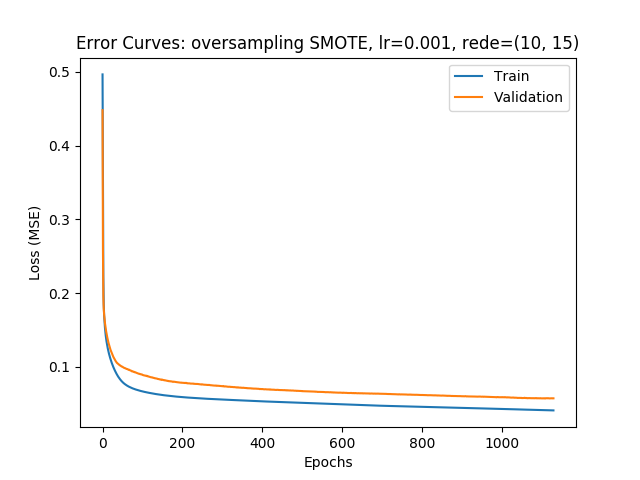

<IPython.core.display.Javascript object>


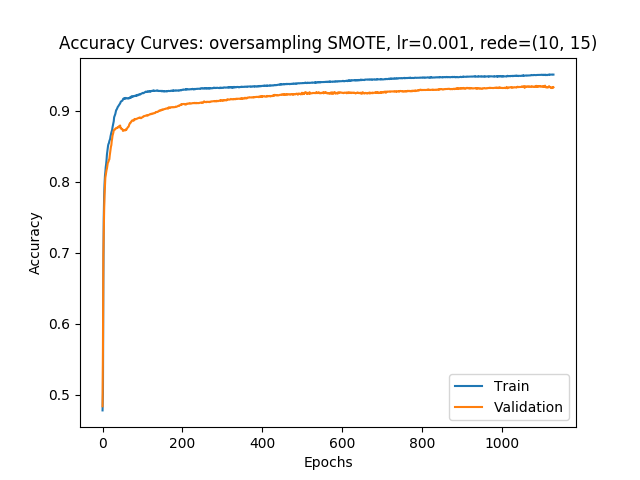

Matriz de confusão
[[1800   98]
 [   8   56]]

Train Loss:       0.0412
Validation Loss:  0.0569
Accuracy:         0.9460
MSE:              0.0540
AUROC:            0.9380


In [28]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history,graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 1s - loss: 0.2772 - acc: 0.6121 - val_loss: 0.1753 - val_acc: 0.7363
Epoch 2/100000
7592/7592 [==============================] - 1s - loss: 0.1385 - acc: 0.8119 - val_loss: 0.1431 - val_acc: 0.8151
Epoch 3/100000
7592/7592 [==============================] - 1s - loss: 0.1195 - acc: 0.8483 - val_loss: 0.1353 - val_acc: 0.8559
Epoch 4/100000
7592/7592 [==============================] - 1s - loss: 0.1117 - acc: 0.8697 - val_loss: 0.1304 - val_acc: 0.8749
Epoch 5/100000
7592/7592 [==============================] - 1s - loss: 0.1069 - acc: 0.8821 - val_loss: 0.1270 - val_acc: 0.8867
Epoch 6/100000
7592/7592 [==============================] - 1s - loss: 0.1035 - acc: 0.8890 - val_loss: 0.1240 - val_acc: 0.8867
Epoch 7/100000
7592/7592 [==============================] - 1s - loss: 0.1008 - acc: 0.8942 - val_loss: 0.1217 - val_acc: 0.8896
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 1s - loss: 0.0716 - acc: 0.9158 - val_loss: 0.0856 - val_acc: 0.9020
Epoch 64/100000
7592/7592 [==============================] - 1s - loss: 0.0713 - acc: 0.9161 - val_loss: 0.0854 - val_acc: 0.9020
Epoch 65/100000
7592/7592 [==============================] - 1s - loss: 0.0711 - acc: 0.9165 - val_loss: 0.0853 - val_acc: 0.9017
Epoch 66/100000
7592/7592 [==============================] - 1s - loss: 0.0709 - acc: 0.9173 - val_loss: 0.0848 - val_acc: 0.9023
Epoch 67/100000
7592/7592 [==============================] - 1s - loss: 0.0708 - acc: 0.9164 - val_loss: 0.0847 - val_acc: 0.9020
Epoch 68/100000
7592/7592 [==============================] - 1s - loss: 0.0706 - acc: 0.9168 - val_loss: 0.0843 - val_acc: 0.9020
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0704 - acc: 0.9171 - val_loss: 0.0841 - val_acc: 0.9020
Epoch 70/100000
7592/7592 [==============================] - 1s - loss: 0.0702 - acc: 0.9165 - val_loss: 0

7592/7592 [==============================] - 1s - loss: 0.0630 - acc: 0.9198 - val_loss: 0.0769 - val_acc: 0.9017
Epoch 126/100000
7592/7592 [==============================] - 1s - loss: 0.0629 - acc: 0.9198 - val_loss: 0.0768 - val_acc: 0.9025
Epoch 127/100000
7592/7592 [==============================] - 1s - loss: 0.0628 - acc: 0.9204 - val_loss: 0.0769 - val_acc: 0.9009
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9198 - val_loss: 0.0768 - val_acc: 0.9012
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9200 - val_loss: 0.0767 - val_acc: 0.9012
Epoch 130/100000
7592/7592 [==============================] - 1s - loss: 0.0625 - acc: 0.9199 - val_loss: 0.0766 - val_acc: 0.9012
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9200 - val_loss: 0.0766 - val_acc: 0.9009
Epoch 132/100000
7592/7592 [==============================] - 1s - loss: 0.0623 - acc: 0.9200 - val_

7592/7592 [==============================] - 1s - loss: 0.0568 - acc: 0.9305 - val_loss: 0.0719 - val_acc: 0.9023
Epoch 188/100000
7592/7592 [==============================] - 1s - loss: 0.0567 - acc: 0.9311 - val_loss: 0.0719 - val_acc: 0.9020
Epoch 189/100000
7592/7592 [==============================] - 1s - loss: 0.0566 - acc: 0.9307 - val_loss: 0.0718 - val_acc: 0.9025
Epoch 190/100000
7592/7592 [==============================] - 1s - loss: 0.0565 - acc: 0.9316 - val_loss: 0.0717 - val_acc: 0.9023
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9314 - val_loss: 0.0716 - val_acc: 0.9025
Epoch 192/100000
7592/7592 [==============================] - 1s - loss: 0.0563 - acc: 0.9318 - val_loss: 0.0714 - val_acc: 0.9028
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9319 - val_loss: 0.0714 - val_acc: 0.9025
Epoch 194/100000
7592/7592 [==============================] - 1s - loss: 0.0562 - acc: 0.9320 - val_

7592/7592 [==============================] - 1s - loss: 0.0526 - acc: 0.9361 - val_loss: 0.0675 - val_acc: 0.9089
Epoch 250/100000
7592/7592 [==============================] - 2s - loss: 0.0525 - acc: 0.9366 - val_loss: 0.0674 - val_acc: 0.9094
Epoch 251/100000
7592/7592 [==============================] - 1s - loss: 0.0524 - acc: 0.9369 - val_loss: 0.0673 - val_acc: 0.9094
Epoch 252/100000
7592/7592 [==============================] - 1s - loss: 0.0524 - acc: 0.9364 - val_loss: 0.0674 - val_acc: 0.9083
Epoch 253/100000
7592/7592 [==============================] - 1s - loss: 0.0523 - acc: 0.9365 - val_loss: 0.0674 - val_acc: 0.9083
Epoch 254/100000
7592/7592 [==============================] - 1s - loss: 0.0523 - acc: 0.9369 - val_loss: 0.0672 - val_acc: 0.9091
Epoch 255/100000
7592/7592 [==============================] - 1s - loss: 0.0522 - acc: 0.9365 - val_loss: 0.0672 - val_acc: 0.9083
Epoch 256/100000
7592/7592 [==============================] - 1s - loss: 0.0522 - acc: 0.9361 - val_

7592/7592 [==============================] - 1s - loss: 0.0498 - acc: 0.9390 - val_loss: 0.0653 - val_acc: 0.9104
Epoch 312/100000
7592/7592 [==============================] - 1s - loss: 0.0498 - acc: 0.9391 - val_loss: 0.0654 - val_acc: 0.9107
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9397 - val_loss: 0.0653 - val_acc: 0.9112
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9394 - val_loss: 0.0653 - val_acc: 0.9115
Epoch 315/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9394 - val_loss: 0.0651 - val_acc: 0.9104
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9391 - val_loss: 0.0653 - val_acc: 0.9110
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9395 - val_loss: 0.0651 - val_acc: 0.9102
Epoch 318/100000
7592/7592 [==============================] - 1s - loss: 0.0495 - acc: 0.9391 - val_

7592/7592 [==============================] - 1s - loss: 0.0477 - acc: 0.9418 - val_loss: 0.0638 - val_acc: 0.9112
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0477 - acc: 0.9418 - val_loss: 0.0638 - val_acc: 0.9112
Epoch 375/100000
7592/7592 [==============================] - 1s - loss: 0.0477 - acc: 0.9419 - val_loss: 0.0637 - val_acc: 0.9112
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0477 - acc: 0.9415 - val_loss: 0.0637 - val_acc: 0.9120
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9416 - val_loss: 0.0637 - val_acc: 0.9117
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9419 - val_loss: 0.0637 - val_acc: 0.9123
Epoch 379/100000
7592/7592 [==============================] - 1s - loss: 0.0476 - acc: 0.9409 - val_loss: 0.0638 - val_acc: 0.9125
Epoch 380/100000
7592/7592 [==============================] - 1s - loss: 0.0475 - acc: 0.9416 - val_

7592/7592 [==============================] - 1s - loss: 0.0460 - acc: 0.9426 - val_loss: 0.0625 - val_acc: 0.9175
Epoch 436/100000
7592/7592 [==============================] - 1s - loss: 0.0460 - acc: 0.9430 - val_loss: 0.0624 - val_acc: 0.9173
Epoch 437/100000
7592/7592 [==============================] - 1s - loss: 0.0460 - acc: 0.9428 - val_loss: 0.0624 - val_acc: 0.9181
Epoch 438/100000
7592/7592 [==============================] - 1s - loss: 0.0460 - acc: 0.9431 - val_loss: 0.0624 - val_acc: 0.9181
Epoch 439/100000
7592/7592 [==============================] - 1s - loss: 0.0459 - acc: 0.9427 - val_loss: 0.0624 - val_acc: 0.9170
Epoch 440/100000
7592/7592 [==============================] - 1s - loss: 0.0459 - acc: 0.9430 - val_loss: 0.0624 - val_acc: 0.9175
Epoch 441/100000
7592/7592 [==============================] - 1s - loss: 0.0459 - acc: 0.9431 - val_loss: 0.0623 - val_acc: 0.9178
Epoch 442/100000
7592/7592 [==============================] - 1s - loss: 0.0459 - acc: 0.9428 - val_

7592/7592 [==============================] - 1s - loss: 0.0446 - acc: 0.9449 - val_loss: 0.0610 - val_acc: 0.9194
Epoch 498/100000
7592/7592 [==============================] - 1s - loss: 0.0446 - acc: 0.9445 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 499/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9452 - val_loss: 0.0610 - val_acc: 0.9197
Epoch 500/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9449 - val_loss: 0.0609 - val_acc: 0.9204
Epoch 501/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9451 - val_loss: 0.0609 - val_acc: 0.9194
Epoch 502/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9449 - val_loss: 0.0609 - val_acc: 0.9204
Epoch 503/100000
7592/7592 [==============================] - 1s - loss: 0.0445 - acc: 0.9451 - val_loss: 0.0608 - val_acc: 0.9202
Epoch 504/100000
7592/7592 [==============================] - 1s - loss: 0.0444 - acc: 0.9448 - val_

7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9469 - val_loss: 0.0596 - val_acc: 0.9231
Epoch 560/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9472 - val_loss: 0.0596 - val_acc: 0.9231
Epoch 561/100000
7592/7592 [==============================] - 1s - loss: 0.0433 - acc: 0.9469 - val_loss: 0.0596 - val_acc: 0.9236
Epoch 562/100000
7592/7592 [==============================] - 0s - loss: 0.0433 - acc: 0.9468 - val_loss: 0.0596 - val_acc: 0.9233
Epoch 563/100000
7592/7592 [==============================] - 0s - loss: 0.0433 - acc: 0.9474 - val_loss: 0.0595 - val_acc: 0.9233
Epoch 564/100000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9474 - val_loss: 0.0596 - val_acc: 0.9241
Epoch 565/100000
7592/7592 [==============================] - 1s - loss: 0.0432 - acc: 0.9469 - val_loss: 0.0595 - val_acc: 0.9236
Epoch 566/100000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9470 - val_

7592/7592 [==============================] - 1s - loss: 0.0423 - acc: 0.9480 - val_loss: 0.0586 - val_acc: 0.9249
Epoch 622/100000
7592/7592 [==============================] - 1s - loss: 0.0423 - acc: 0.9481 - val_loss: 0.0586 - val_acc: 0.9252
Epoch 623/100000
7592/7592 [==============================] - 1s - loss: 0.0422 - acc: 0.9484 - val_loss: 0.0586 - val_acc: 0.9249
Epoch 624/100000
7592/7592 [==============================] - 1s - loss: 0.0422 - acc: 0.9480 - val_loss: 0.0586 - val_acc: 0.9249
Epoch 625/100000
7592/7592 [==============================] - 1s - loss: 0.0422 - acc: 0.9481 - val_loss: 0.0586 - val_acc: 0.9249
Epoch 626/100000
7592/7592 [==============================] - 1s - loss: 0.0422 - acc: 0.9480 - val_loss: 0.0585 - val_acc: 0.9249
Epoch 627/100000
7592/7592 [==============================] - 1s - loss: 0.0422 - acc: 0.9481 - val_loss: 0.0585 - val_acc: 0.9252
Epoch 628/100000
7592/7592 [==============================] - 1s - loss: 0.0422 - acc: 0.9480 - val_

7592/7592 [==============================] - 1s - loss: 0.0414 - acc: 0.9489 - val_loss: 0.0579 - val_acc: 0.9270
Epoch 684/100000
7592/7592 [==============================] - 1s - loss: 0.0414 - acc: 0.9489 - val_loss: 0.0579 - val_acc: 0.9273
Epoch 685/100000
7592/7592 [==============================] - 0s - loss: 0.0414 - acc: 0.9490 - val_loss: 0.0579 - val_acc: 0.9283
Epoch 686/100000
7592/7592 [==============================] - 1s - loss: 0.0414 - acc: 0.9489 - val_loss: 0.0579 - val_acc: 0.9270
Epoch 687/100000
7592/7592 [==============================] - 1s - loss: 0.0414 - acc: 0.9485 - val_loss: 0.0579 - val_acc: 0.9268
Epoch 688/100000
7592/7592 [==============================] - 1s - loss: 0.0414 - acc: 0.9490 - val_loss: 0.0578 - val_acc: 0.9273
Epoch 689/100000
7592/7592 [==============================] - 1s - loss: 0.0413 - acc: 0.9488 - val_loss: 0.0578 - val_acc: 0.9273
Epoch 690/100000
7592/7592 [==============================] - 1s - loss: 0.0413 - acc: 0.9486 - val_

7592/7592 [==============================] - 1s - loss: 0.0406 - acc: 0.9502 - val_loss: 0.0574 - val_acc: 0.9291
Epoch 746/100000
7592/7592 [==============================] - 1s - loss: 0.0406 - acc: 0.9499 - val_loss: 0.0574 - val_acc: 0.9297
Epoch 747/100000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9499 - val_loss: 0.0574 - val_acc: 0.9302
Epoch 748/100000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9496 - val_loss: 0.0574 - val_acc: 0.9297
Epoch 749/100000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9498 - val_loss: 0.0574 - val_acc: 0.9294
Epoch 750/100000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9497 - val_loss: 0.0574 - val_acc: 0.9291
Epoch 751/100000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9501 - val_loss: 0.0574 - val_acc: 0.9299
Epoch 752/100000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9494 - val_

7592/7592 [==============================] - 1s - loss: 0.0400 - acc: 0.9510 - val_loss: 0.0571 - val_acc: 0.9310
Epoch 808/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9509 - val_loss: 0.0571 - val_acc: 0.9310
Epoch 809/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9514 - val_loss: 0.0571 - val_acc: 0.9310
Epoch 810/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9513 - val_loss: 0.0571 - val_acc: 0.9312
Epoch 811/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9509 - val_loss: 0.0571 - val_acc: 0.9310
Epoch 812/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9513 - val_loss: 0.0571 - val_acc: 0.9312
Epoch 813/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9506 - val_loss: 0.0571 - val_acc: 0.9312
Epoch 814/100000
7592/7592 [==============================] - 1s - loss: 0.0399 - acc: 0.9513 - val_

7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9522 - val_loss: 0.0568 - val_acc: 0.9318
Epoch 870/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9519 - val_loss: 0.0569 - val_acc: 0.9318
Epoch 871/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9517 - val_loss: 0.0568 - val_acc: 0.9318
Epoch 872/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9526 - val_loss: 0.0568 - val_acc: 0.9320
Epoch 873/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9521 - val_loss: 0.0568 - val_acc: 0.9320
Epoch 874/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9515 - val_loss: 0.0568 - val_acc: 0.9318
Epoch 875/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9519 - val_loss: 0.0568 - val_acc: 0.9320
Epoch 876/100000
7592/7592 [==============================] - 1s - loss: 0.0393 - acc: 0.9522 - val_

7592/7592 [==============================] - 1s - loss: 0.0388 - acc: 0.9528 - val_loss: 0.0567 - val_acc: 0.9315
Epoch 932/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9528 - val_loss: 0.0566 - val_acc: 0.9315
Epoch 933/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9527 - val_loss: 0.0566 - val_acc: 0.9315
Epoch 934/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9531 - val_loss: 0.0566 - val_acc: 0.9315
Epoch 935/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9530 - val_loss: 0.0567 - val_acc: 0.9315
Epoch 936/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9539 - val_loss: 0.0567 - val_acc: 0.9312
Epoch 937/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9528 - val_loss: 0.0566 - val_acc: 0.9312
Epoch 938/100000
7592/7592 [==============================] - 1s - loss: 0.0387 - acc: 0.9532 - val_

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1376/1962 [====================>.........] - ETA: 0s[0.042216051174574568, 0.94852191641182471]


<IPython.core.display.Javascript object>


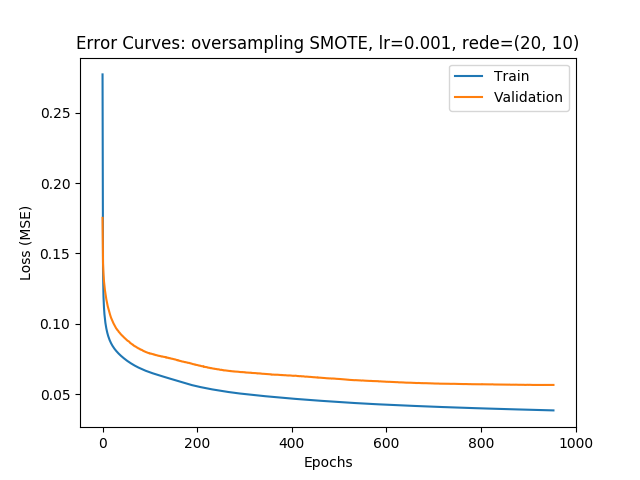

<IPython.core.display.Javascript object>


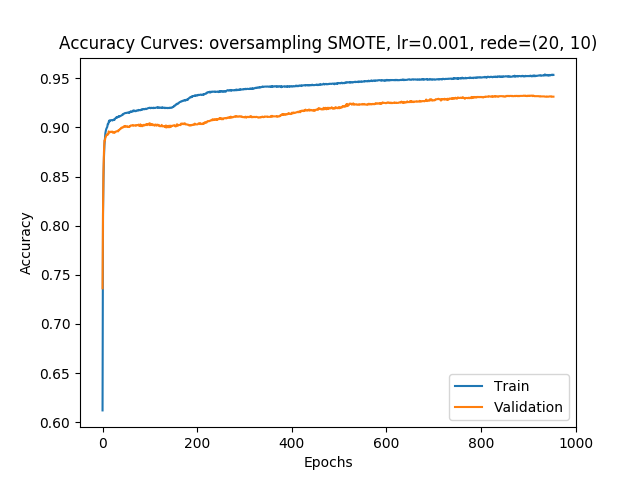

Matriz de confusão
[[1805   93]
 [   8   56]]

Train Loss:       0.0387
Validation Loss:  0.0566
Accuracy:         0.9485
MSE:              0.0515
AUROC:            0.9463


In [32]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1776 - acc: 0.8301 - val_loss: 0.1240 - val_acc: 0.8841
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0898 - acc: 0.9063 - val_loss: 0.1185 - val_acc: 0.8867
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9057 - val_loss: 0.1118 - val_acc: 0.8878
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9054 - val_loss: 0.1183 - val_acc: 0.8867
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9038 - val_loss: 0.1121 - val_acc: 0.8909
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9054 - val_loss: 0.1099 - val_acc: 0.8894
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0879 - acc: 0.9040 - val_loss: 0.1097 - val_acc: 0.8904
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9037 - val_loss: 0.1131 - val_acc: 0.8886
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9038 - val_loss: 0.1085 - val_acc: 0.8901
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1175 - val_acc: 0.8801
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9053 - val_loss: 0.1240 - val_acc: 0.8754
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9056 - val_loss: 0.1107 - val_acc: 0.8917
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9053 - val_loss: 0.1118 - val_acc: 0.8878
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9060 - val_loss: 0.1076 - val_acc: 0.8915
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9042 - val_loss: 0.1139 -

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9058 - val_loss: 0.1070 - val_acc: 0.8925
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9040 - val_loss: 0.1108 - val_acc: 0.8841
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9063 - val_loss: 0.1220 - val_acc: 0.8783
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0877 - acc: 0.9038 - val_loss: 0.1109 - val_acc: 0.8870
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9065 - val_loss: 0.1197 - val_acc: 0.8820
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1160 - val_acc: 0.8807
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9049 - val_loss: 0.1119 - val_acc: 0.8867
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9033 - val_loss: 0.1123 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9031 - val_loss: 0.1102 - val_acc: 0.8899
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9045 - val_loss: 0.1107 - val_acc: 0.8870
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9033 - val_loss: 0.1106 - val_acc: 0.8894
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9042 - val_loss: 0.1115 - val_acc: 0.8888
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9044 - val_loss: 0.1135 - val_acc: 0.8854
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9023 - val_loss: 0.1148 - val_acc: 0.8822
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9040 - val_loss: 0.1049 - val_acc: 0.8925
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9066 - val_loss: 0.1103 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9056 - val_loss: 0.1033 - val_acc: 0.8888
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0.1089 - val_acc: 0.8875
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9024 - val_loss: 0.1182 - val_acc: 0.8862
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0877 - acc: 0.9056 - val_loss: 0.1090 - val_acc: 0.8912
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0879 - acc: 0.9042 - val_loss: 0.1087 - val_acc: 0.8915
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9041 - val_loss: 0.1051 - val_acc: 0.8907
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9044 - val_loss: 0.1092 - val_acc: 0.8904
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9032 - val_loss: 0.1091 -

7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9032 - val_loss: 0.1189 - val_acc: 0.8791
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9057 - val_loss: 0.1062 - val_acc: 0.8915
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1202 - val_acc: 0.8775
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9025 - val_loss: 0.1128 - val_acc: 0.8846
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9057 - val_loss: 0.1206 - val_acc: 0.8751
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9040 - val_loss: 0.1209 - val_acc: 0.8772
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9044 - val_loss: 0.1085 - val_acc: 0.8894
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1072 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9040 - val_loss: 0.1047 - val_acc: 0.8917
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1169 - val_acc: 0.8780
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9046 - val_loss: 0.1076 - val_acc: 0.8909
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1109 - val_acc: 0.8904
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9029 - val_loss: 0.1137 - val_acc: 0.8891
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9041 - val_loss: 0.1121 - val_acc: 0.8846
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9041 - val_loss: 0.1136 - val_acc: 0.8891
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9025 - val_loss: 0.1128 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9038 - val_loss: 0.1128 - val_acc: 0.8830
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9052 - val_loss: 0.1071 - val_acc: 0.8907
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0.1063 - val_acc: 0.8907
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9033 - val_loss: 0.1118 - val_acc: 0.8901
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1133 - val_acc: 0.8928
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9036 - val_loss: 0.1209 - val_acc: 0.8778
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9025 - val_loss: 0.1181 - val_acc: 0.8849
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9053 - val_loss: 0.1136 -

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9037 - val_loss: 0.1052 - val_acc: 0.8891
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9044 - val_loss: 0.1279 - val_acc: 0.8704
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1174 - val_acc: 0.8825
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9061 - val_loss: 0.1054 - val_acc: 0.8894
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9052 - val_loss: 0.1206 - val_acc: 0.8830
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1115 - val_acc: 0.8867
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9038 - val_loss: 0.1266 - val_acc: 0.8678
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9054 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1068 - val_acc: 0.8907
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8870
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9052 - val_loss: 0.1136 - val_acc: 0.8844
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9061 - val_loss: 0.1092 - val_acc: 0.8844
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9053 - val_loss: 0.1229 - val_acc: 0.8791
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0.1130 - val_acc: 0.8875
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9054 - val_loss: 0.1174 - val_acc: 0.8809
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9044 - val_loss: 0.1142 - val_acc: 0.8883
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9063 - val_loss: 0.1157 - val_acc: 0.8844
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9020 - val_loss: 0.1151 - val_acc: 0.8854
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9050 - val_loss: 0.1141 - val_acc: 0.8849
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9045 - val_loss: 0.1193 - val_acc: 0.8762
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0.1085 - val_acc: 0.8915
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9057 - val_loss: 0.1177 - val_acc: 0.8796
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9061 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9045 - val_loss: 0.1175 - val_acc: 0.8846
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1048 - val_acc: 0.8917
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9060 - val_loss: 0.1114 - val_acc: 0.8891
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9044 - val_loss: 0.1160 - val_acc: 0.8822
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9036 - val_loss: 0.1165 - val_acc: 0.8825
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1128 - val_acc: 0.8894
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9015 - val_loss: 0.1183 - val_acc: 0.8809
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9053 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9031 - val_loss: 0.1093 - val_acc: 0.8923
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9019 - val_loss: 0.1179 - val_acc: 0.8815
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9058 - val_loss: 0.1090 - val_acc: 0.8862
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9058 - val_loss: 0.1113 - val_acc: 0.8870
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9069 - val_loss: 0.1081 - val_acc: 0.8891
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1176 - val_acc: 0.8854
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0.1071 - val_acc: 0.8888
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9044 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1183 - val_acc: 0.8825
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1093 - val_acc: 0.8883
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9053 - val_loss: 0.1114 - val_acc: 0.8925
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8899
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9041 - val_loss: 0.1110 - val_acc: 0.8923
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8907
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9040 - val_loss: 0.1118 - val_acc: 0.8838
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0865 - acc: 0.9063 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9031 - val_loss: 0.1095 - val_acc: 0.8909
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9067 - val_loss: 0.1097 - val_acc: 0.8904
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9042 - val_loss: 0.1118 - val_acc: 0.8862
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1140 - val_acc: 0.8833
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8854
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1069 - val_acc: 0.8886
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9035 - val_loss: 0.1109 - val_acc: 0.8888
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9037 - val_loss: 0.1083 - val_acc: 0.8917
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9032 - val_loss: 0.1061 - val_acc: 0.8896
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9038 - val_loss: 0.1164 - val_acc: 0.8859
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9042 - val_loss: 0.1103 - val_acc: 0.8896
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9046 - val_loss: 0.1107 - val_acc: 0.8862
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9046 - val_loss: 0.1109 - val_acc: 0.8838
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9058 - val_loss: 0.1189 - val_acc: 0.8809
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9031 - val_loss: 0

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.062036256872641568, 0.9327217125989854]


<IPython.core.display.Javascript object>


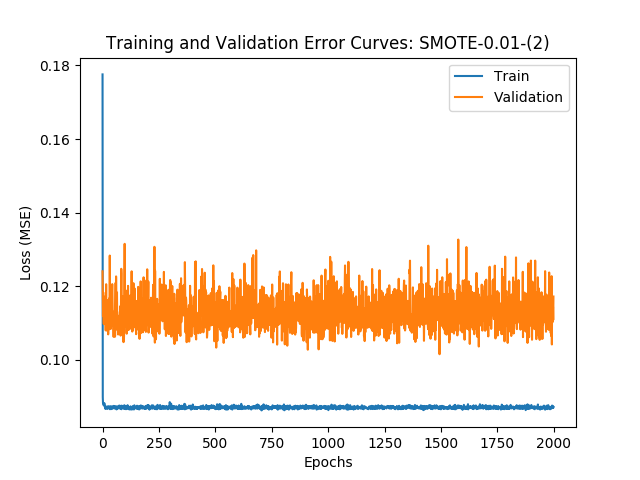

<IPython.core.display.Javascript object>


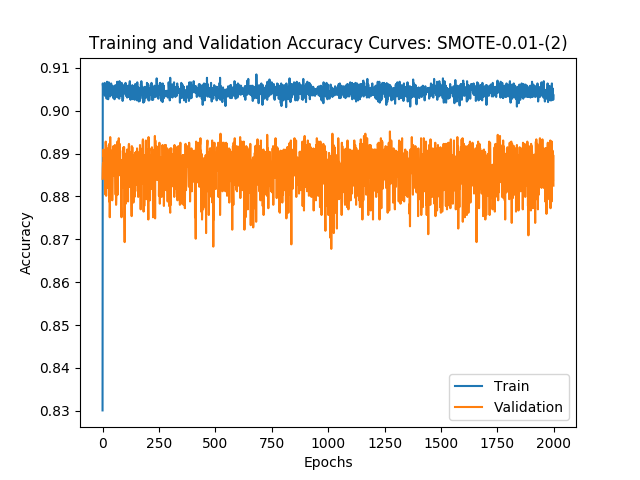

Matriz de confusão
[[1778  120]
 [   9   55]]

Train Loss:       0.0869
Validation Loss:  0.1015
Accuracy:         0.9343
MSE:              0.0657
AUROC:            0.9496


In [32]:
plot_training_error_curves(history, graficoName + "(2)")
plot_training_acc_curves(history, graficoName + "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(4)")
plot_training_acc_curves(history, graficoName + "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))